# Cài đặt YOLOv2

Nguồn tham khảo:
- https://www.kaggle.com/trungthanhnguyen0502/yolo-v2-from-scratch/notebook
- https://www.maskaravivek.com/post/yolov2/


### Outline:
0. Chuẩn bị dữ liệu
1. Anchor box clustering với thuật toán K-Means
2. Xử lý Input và Label
3. Lớp MyGenerator
4. Kiến trúc mô hình
5. Hàm loss
6. Training

<a id='a'></a>
## 0. Chuẩn bị dữ liệu

Ta sẽ sử dụng tập dữ liệu <a href="http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#data">**Pascal VOC 2012**</a>
  

In [1]:
CLASSES = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle',
           'bus',        'car',      'cat',  'chair',     'cow',
           'diningtable', 'dog',    'horse',  'motorbike', 'person',
           'pottedplant', 'sheep',  'sofa',   'train',   'tvmonitor']

In [2]:
imgs_folder = "VOC2012/JPEGImages/"
anns_folder = "VOC2012/Annotations/"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
%matplotlib inline

Các annotations gốc đang ở dạng XML nên ta sẽ đọc chúng là lưu vào 1 dictionary.

In [4]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, classes):
    '''
    Argments:
        `ann_dir`: annotations folder
        `img_dir`: images folder
    Return:
        `all_anns`: dictionary of image annotations (1 annotation per image)
        `class_counts`: dictionary (class, the number of obj found)    
    '''
    all_anns = []
    class_counts = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        tree = ET.parse(ann_dir + ann)

        img = {'object':[]}
        
        for ele in tree.iter():
            if 'filename' in ele.tag:
                path_to_image = img_dir + ele.text
                img['filename'] = path_to_image
                # If this image doesn't exist, raise an exception
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)

            # width and height of image
            if 'width' in ele.tag:
                img['width'] = int(ele.text)

            if 'height' in ele.tag:
                img['height'] = int(ele.text)

            # bounding box information: class and coordinates
            if 'object' in ele.tag or 'part' in ele.tag:
                obj = {}
                
                for attr in list(ele):
                    if 'name' in attr.tag:
                        # class
                        obj['name'] = attr.text
                        
                        # If this class is not in CLASSES, skip this element
                        if obj['name'] not in classes:
                            break
                        else:
                            img['object'] += [obj]

                        # Increase the class_count
                        if obj['name'] in class_counts:
                            class_counts[obj['name']] += 1
                        else:
                            class_counts[obj['name']]  = 1

                    # coodinates
                    if 'bndbox' in attr.tag:
                        for tmp in list(attr):
                            if 'xmin' in tmp.tag:
                                obj['xmin'] = int(round(float(tmp.text)))
                            if 'ymin' in tmp.tag:
                                obj['ymin'] = int(round(float(tmp.text)))
                            if 'xmax' in tmp.tag:
                                obj['xmax'] = int(round(float(tmp.text)))
                            if 'ymax' in tmp.tag:
                                obj['ymax'] = int(round(float(tmp.text)))

        # If this image doesn't contain any obj, skip it
        if len(img['object']) > 0:
            all_anns += [img]
                        
    return all_anns, class_counts

In [5]:
all_anns, class_counts = parse_annotation(anns_folder, imgs_folder, CLASSES)
print('No. images (and annotations) =', len(all_anns))

No. images (and annotations) = 17125


In ra một số annotation:

In [6]:
all_anns[:2]

[{'object': [{'name': 'person',
    'xmin': 174,
    'ymin': 101,
    'xmax': 349,
    'ymax': 351}],
  'filename': 'VOC2012/JPEGImages/2007_000027.jpg',
  'width': 486,
  'height': 500},
 {'object': [{'name': 'aeroplane',
    'xmin': 104,
    'ymin': 78,
    'xmax': 375,
    'ymax': 183},
   {'name': 'aeroplane', 'xmin': 133, 'ymin': 88, 'xmax': 197, 'ymax': 123},
   {'name': 'person', 'xmin': 195, 'ymin': 180, 'xmax': 213, 'ymax': 229},
   {'name': 'person', 'xmin': 26, 'ymin': 189, 'xmax': 44, 'ymax': 238}],
  'filename': 'VOC2012/JPEGImages/2007_000032.jpg',
  'width': 500,
  'height': 281}]

Visualize số lượng object tìm thấy của mỗi class:

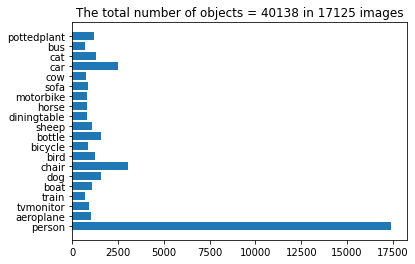

In [7]:
y_ticks = np.arange(len(class_counts))

plt.barh(y_ticks, list(class_counts.values()))

plt.yticks(y_ticks, list(class_counts.keys()))

plt.title("The total number of objects = {} in {} images".format(
    np.sum(list(class_counts.values())), len(all_anns)
))
plt.show()


Với mục đích minh họa thuật toán, ta sẽ chỉ sử dụng tập training và validation:

In [8]:
all_anns = np.array(all_anns)

np.random.seed(666)
np.random.shuffle(all_anns)

ratio = 0.8

train_anns = all_anns[: int(0.8 * len(all_anns))]
val_anns = all_anns[int(0.8 * len(all_anns)):]

<a id='1'></a>
## 1. Anchor box clustering với thuật toán K-Means

Từ các nhược điểm mô YOLOv1 như không dự đoán tốt những vật thể có kích thước khác nhau ở vùng lân cận, YOLOv2 đã sử dụng các anchor box (ý tưởng này thực chất được tham khảo từ các thuật toán RCNN).

Tại mỗi ô lưới sẽ có một số lượng anchor box nhất định, từ đó làm cơ sở để dự đoán các bounding box cho đối tượng nào đó. 

***Ví dụ***: Sử dụng anchor box có kích thước rộng + thấp sẽ có khả năng xác định được những vật thể dạng như chiếc xe ô tô

Ta cần xác định trước những siêu tham số sau:
- Số lượng anchor box
- Kích thước của các anchor box

Ta không nên chọn "bằng tay" mà cần có một phương pháp để chọn sao cho phù hợp với tập dữ liệu đang dùng. Trong paper của YOLOv2, các tác giả sử dụng thuật toán K-Means. Ta sẽ phân cụm các bounding box có trong label, với:
- Số lượng cụm = Số lượng anchor box sẽ dùng cho YOLOv2
- Mỗi phần tử là vector 2 chiều, có ý nghĩa là (width, height) của anchor box

Độ đo được sử dụng là IOU giữa bounding box trong dữ liệu và tâm của các cụm






#### Lấy ra giá trị width, height của toàn bộ bounding box trong tập dữ liệu

Do kích thước của các ảnh là khác nhau nên ta sẽ chuẩn hóa width, height của các bounding box trong ảnh đó bằng cách chia chúng cho width và height của ảnh

In [62]:
train_wh = []
for ann in train_anns:
    img_width = float(ann['width'])
    img_height = float(ann['height'])
    for obj in ann["object"]:
        # normalize
        w = (obj["xmax"] - obj["xmin"]) / img_width
        h = (obj["ymax"] - obj["ymin"]) / img_height
        train_wh.append([w, h])

train_wh = np.array(train_wh)
print(train_wh.shape)

(31979, 2)


#### Tính IOU

Ta chỉ dựa vào các thông tin width, height của 2 box để tính IOU, do đó ta xem chúng có chung đỉnh top-left.

In [9]:
def iou(box1, box2):
    '''
    Compute the IOU value of `box1` and `box2`
    Arguments:
        `box1` and `box2`: a numpy array of shape (2,), indicates [w, h]
    Return:
        IOU value
    '''
    x = np.minimum(box1[0], box2[0]) 
    y = np.minimum(box1[1], box2[1])

    intersection = x * y
    box1_area = box1[0] * box1[1]
    box2_area = box2[0] * box2[1]
    union = box1_area + box2_area - intersection

    return intersection / union

#### Thuật toán K-Means

Lưu ý rằng ta sẽ sử dụng độ đo IOU (thay vì Euclid như bản gốc) và phép cập nhật clusters sẽ dùng median (thay vì mean)

In [51]:
from sklearn.metrics import pairwise_distances

def isConverged(X_old, X_new):
    return set(tuple(X) for X in X_old) == set(tuple(X) for X in X_new)


def kmeans(boxes, n_cluster, seed=2022):
    '''
    K-means clustering with IOU metric.
    Arguments:
        `boxes`: a numpy array of shape (N, 2), indicates [w, h]
        `n_cluster`: the number of clusters
        `seed`: random seed
    Return:
        `clusters`: a numpy array of shape (`n_cluster`, 2)
        `labels`: a numpy array of shape (N, 1)
        `mean_distances`: the mean value of distances between each box and its cluster centroids
    '''
    n_box = len(boxes)
    np.random.seed(seed)

    # initialize the clusters
    clusters = boxes[np.random.choice(n_box, n_cluster, replace=False)]

    while True:
        # assign labels to each box
        distances = 1 - pairwise_distances(boxes, clusters, metric=iou)
        labels = np.argmin(distances, axis=1)

        # update clusters
        new_cluster = np.zeros((n_cluster, boxes.shape[1]))
        for i in range(n_cluster):
            new_cluster[i] = np.mean(boxes[labels == i], axis=0)

        if isConverged(clusters, new_cluster):
            break
        
        clusters = new_cluster

    mean_distances = np.mean(distances[np.arange(n_box), labels])
    return clusters, labels, mean_distances

Chạy K-Means với giá trị k từ 2 đến 8 để tìm ra giá trị tốt nhất:

In [80]:
results = {}
for k in range(2, 9):
    clusters, labels, mean_dist = kmeans(train_wh, k)

    result = {"clusters": clusters,
              "labels": labels,
              "mean_dist":  mean_dist}

    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(
        k, 1 - mean_dist))

    results[k] = result


 2 clusters: mean IoU = 0.4649
 3 clusters: mean IoU = 0.5386
 4 clusters: mean IoU = 0.5800
 5 clusters: mean IoU = 0.6016
 6 clusters: mean IoU = 0.6221
 7 clusters: mean IoU = 0.6431
 8 clusters: mean IoU = 0.6578


Visualize kết quả K-Means và chọn giá trị k với ***Eblow method***

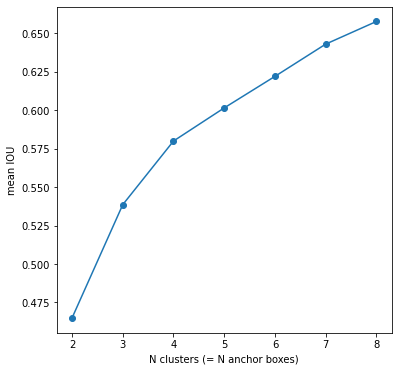

In [81]:
plt.figure(figsize=(6,6))

plt.plot(np.arange(2, 9),
         [1 - results[k]["mean_dist"] for k in range(2, 9)],"o-")

plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

Dựa vào biểu đồ trên, ta chọn **k = 4**

In [82]:
n_anchor_box = 4
results[n_anchor_box]["clusters"]

array([[0.08264212, 0.13575117],
       [0.41898774, 0.6221668 ],
       [0.80433065, 0.77523612],
       [0.20665115, 0.3896164 ]])

Để ý rằng:
- (0.08264212, 0.13575117) $\rightarrow$ anchor box rất nhỏ
- (0.20665115, 0.3896164) $\rightarrow$ anchor box nhỏ
- (0.41898774, 0.6221668) $\rightarrow$ anchor box vừa
- (0.80433065, 0.77523612) $\rightarrow$ anchor box lớn

Các giá trị này sẽ được ta sử dụng trong các phần tiếp theo

In [10]:
ANCHORS = np.array([[0.08264212, 0.13575117],
                    [0.41898774, 0.6221668],
                    [0.80433065, 0.77523612],
                    [0.20665115, 0.3896164]])

## 2. Xử lý Input và Label

### 2.1. Input encoding

Với mỗi ảnh đầu vào, ta sẽ resize nó về 1 kích thước (416 x 416 hoặc 608 x 608). Khi đó, các tọa độ $x_{min}$, $x_{max}$, $y_{min}$, $y_{max}$ của các bounding box cũng sẽ được rescale theo.

***Ví dụ***: Ảnh gốc 600 x 800, tọa độ $x_{min}$ là 200. Ta resize ảnh về 416 x 416. Khi đó
$$ x_{min} \to \frac{x_{min}}{600} * 416$$

In [11]:
import copy

def normalize(image):
    return image / 255.

class ImageReader(object):
    def __init__(self, img_size=416, norm=normalize):
        '''
        Arguments:
            `img_size`: width and height of image (416 or 608)
            `norm`: normalization method
        '''
        self.img_size = img_size
        self.norm = norm

    def fit(self, img_ann):
        '''
        Arguments:
            `img_ann`: a dictionary contains the annotation of an image
        Return:
            `image`: cv2 image that is resized and normalized
            `all_obj`: a list of dictionarys about name and coordinates of objects
        '''
        img_name = img_ann['filename']

        image = cv2.imread(img_name)

        if image is None:
            print('Cannot find ', img_name)
            return

        img_h, img_w, img_c = image.shape

        # Resize and normalize the image
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image[:, :, ::-1]
        if self.norm:
            image = self.norm(image)

        # Rescale object coordinates
        if "object" in img_ann.keys():
            all_objs = copy.deepcopy(img_ann['object'])

            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.img_size) / img_w)
                    obj[attr] = max(min(obj[attr], self.img_size), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.img_size) / img_h)
                    obj[attr] = max(min(obj[attr], self.img_size), 0)
        else:
            return image

        return image, all_objs


Chạy thử lớp `ImageReader`

Input
  object: [{'name': 'person', 'xmax': 287, 'xmin': 242, 'ymax': 220, 'ymin': 125}]
  filename: VOC2012/JPEGImages/2012_000169.jpg
  height: 375
  width: 500
Output
  [{'name': 'person', 'xmax': 238, 'xmin': 201, 'ymax': 244, 'ymin': 138}]


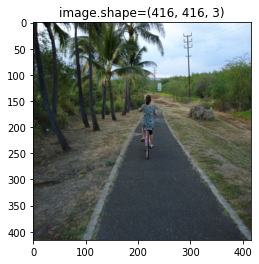

In [12]:
print("Input")
demo_image = train_anns[0]
for key, v in demo_image.items():
    print(f"  {key}: {v}")

print("Output")
inputEncoder = ImageReader(img_size=416, norm=normalize)
image, all_objs = inputEncoder.fit(demo_image)
print(f"  {all_objs}")

plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

### 2.2. Label encoding

### 2.2.1. Từ tọa độ pixel đến tọa độ tương đối
Đối với các thuật toán YOLO, ta không sử dụng các tọa độ $x_{min}$, $x_{max}$, $y_{min}$, $y_{max}$ của các bounding box làm label mà là $x_{center}, y_{center}, width, height$

YOLOv1 xem các đỉnh top-left và bottom-right của mỗi ô lưới tương ứng với các ô (0,0), (1,1). Từ đó, các giá trị tọa độ tâm sẽ được scale về trong các ô lưới chứa nó. Width và height thì sẽ chuẩn hóa về (0,1) dựa theo kích thước ảnh.

Trong phiên bản cài đặt YOLOv2 này, để thuận tiện, ta sẽ thực hiện phương pháp khác như sau:
- Theo paper gốc, ta sử dụng lưới 13 x 13 cho bức ảnh size 416 hoặc 608
- Rescale cả 4 giá trị tọa độ x, y, width, height về [0,13]
    - ***Ví dụ***: Bounding box có width là 150 pixel. Khi đó ta rescale thành $$\frac{150}{416} * 13 = 4.6875$$

In [13]:
def rescale_box(box, img_size=416, grid_size=13):
    '''
    Rescale the box coordinate to our method
    Arguments:
        `box`: an array of shape (4,), indicates [xmin, ymin, xmax, ymax] 
        `img_size`: width and height of image (416 or 608)
        `grid_size`: the number of grid cells on horizontal (or vertical)
    Return:
        `rescaled_box`: a numpy array of shape (4,)
    '''
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    rescaled_box = np.array([x, y, w, h])
    rescaled_box = rescaled_box * grid_size / img_size
    return rescaled_box

### 2.2.2. Label của các anchor box

Kích thước của input, output của YOLOv2 như sau:
- Input: (IMG_SIZE, IMG_SIZE, 3)
- Output: (GRID_SIZE, GRID_SIZE, N_BOX, 4 + 1 + N_CLASS)

Tại mỗi ô lưới, ta sẽ có N_BOX anchor box. Khi đó, nếu trong ô lưới đó có một object A thì trong các anchor box này cần có 1 anchor box chịu trách nhiệm về A, tức là vector (4 + 1 + N_CLASS) chiều tại đó sẽ có giá trị giống với label của object đó (có được từ các annotation).

Tiêu chí chọn ra anchor box phù hợp sẽ là tính IOU giữa anchor box đó với bounding box của object. Hơn nữa, ta sẽ xem chúng có cùng đỉnh top-left là (0, 0), việc tính IOU chỉ cần dựa vào width và height.

Từ đó, ta xây dựng lớp `BestAnchorBoxFinder` như sau:

In [14]:
class BestAnchorBoxFinder:
    def __init__(self, ANCHORS):
        '''
        Arguments:
            `ANCHORS`: a np.array of shape (k, 2) of anchor boxes (found by K-Means)
        '''
        self.anchors = ANCHORS

    def find(self, w, h):
        '''
        Arguments:
            `w`, `h`: width and height of the bounding box
        '''
        best_anchor = -1
        max_iou = -1

        for i in range(len(self.anchors)):
            anchor = self.anchors[i]
            cur_iou = iou((w, h), anchor)
            if max_iou < cur_iou:
                best_anchor = i
                max_iou = cur_iou
                
        return best_anchor

## 3. Lớp MyGenerator

Ta sẽ sử dụng lớp này để fetch dữ liệu theo từng batch trong quá trình training. Các ảnh sẽ được đọc trong mỗi lần fetch. Điều này là cần thiết vì số lượng ảnh rất lớn (17125 ảnh), RAM sẽ không thể đủ để đọc toàn bộ ảnh trong 1 lần.

In [15]:
import tensorflow as tf

Để thuận tiện cho việc truyền tham số vào hàm khởi tạo của `MyGenerator`, ta sử dụng dictionary `config` với các thuộc tính sau:
- `IMG_SIZE`: 416 hoặc 608
- `GRID_SIZE`: số lượng ô lưới trên 1 hàng hoặc cột (ví dụ như 13)
- `BATCH_SIZE`
- `CLASSES`: Các class mà ta sẽ train
- `ANCHORS`: mảng 2 chiều, gồm width và height của các anchor box ta tìm được bằng K-Means
- `TRUE_BOX_BUFFER`: Vì ***một lý do nào đó*** mà nguồn mình thao khảo sử dụng thêm tham số này. Đây là số lượng tối đa các bounding box trong một ảnh (dùng cho việc tính loss, ta sẽ đề cập sau)

In [79]:
class MyGenerator(tf.keras.utils.Sequence):
    def __init__(self, anns, config, norm=normalize, shuffle=True):
        '''
        Arguments:
            `anns`: a list of dictionarys about information of each image, such as name and 
                    coordinates of objects
            `config` : dictionary containing necessary hyper parameters for traning.
        '''
        self.config = config
        self.n_abox = len(self.config['ANCHORS'])
        self.n_classes = len(self.config['CLASSES'])
        self.anns = anns
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_SIZE'], norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.anns)
            
    def __len__(self):
        return int(np.ceil(len(self.anns) / self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        Arguments:
            `idx`: the index of the batch
        
        Return:
            `x_batch`: a np.array of shape (batch_size, image_size, image_size, 3)
            `y_batch`: a np.array of shape (batch_size, grid_size, grid_size, BOX, 4 + 1 + n_class)
            `b_batch`: a np.array of shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)

        Note:
            `b_batch` will be used for calculate loss (?)
        '''

        left = idx * self.config['BATCH_SIZE']
        right = (idx + 1) * self.config['BATCH_SIZE']

        if right > len(self.anns):
            right = len(self.anns)
            left = right - self.config['BATCH_SIZE']

        cnt = 0
        
        x_batch = np.zeros((right - left, self.config['IMAGE_SIZE'], self.config['IMAGE_SIZE'], 3))
        b_batch = np.zeros((right - left, 1, 1, 1, self.config['TRUE_BOX_BUFFER'], 4))
        y_batch = np.zeros((right - left, self.config['GRID_SIZE'],  self.config['GRID_SIZE'], self.n_abox, 4 + 1 + self.n_classes))

        for ann in self.anns[left:right]:
            img, all_objs = self.imageReader.fit(ann)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if  obj['name'] in self.config['CLASSES']:
                    tmp = (obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'])
                    x_new, y_new, w_new, h_new = rescale_box(tmp, img_size=self.config['IMAGE_SIZE'], grid_size=self.config['GRID_SIZE'])
                    
                    grid_x = int(np.floor(x_new))
                    grid_y = int(np.floor(y_new))

                    if grid_x < self.config['GRID_SIZE'] and grid_y < self.config['GRID_SIZE']:
                        class_indx  = self.config['CLASSES'].index(obj['name'])
                        box = [x_new, y_new, w_new, h_new]
                        best_anchor = self.bestAnchorBoxFinder.find(w_new, h_new)

                        # assign the label to y_bacth
                        # coodinates
                        y_batch[cnt, grid_y, grid_x, best_anchor, 0:4] = box
                        # confidence
                        y_batch[cnt, grid_y, grid_x, best_anchor, 4] = 1.
                        # class probability
                        y_batch[cnt, grid_y, grid_x, best_anchor, 5 + class_indx] = 1
                        
                        # assign the true box to b_batch
                        b_batch[cnt, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[cnt] = img
            cnt += 1
        print('gen log')
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

Chạy thử lớp `MyGenerator`

In [17]:
demo_config = {
    'IMAGE_SIZE': 416,
    'GRID_SIZE': 13,
    'ANCHORS': ANCHORS,
    'CLASSES': CLASSES,
    'BATCH_SIZE': 32,
    'TRUE_BOX_BUFFER': 50,
}

In [18]:
demo_generator = MyGenerator(train_anns, demo_config, norm=normalize, shuffle=True)

In [19]:
[x_batch, b_batch], y_batch = demo_generator.__getitem__(idx=0)

In [20]:
print("x_batch = {}".format(x_batch.shape))
print("y_batch = {}".format(y_batch.shape))
print("b_batch = {}".format(b_batch.shape))

x_batch = (32, 416, 416, 3)
y_batch = (32, 13, 13, 4, 25)
b_batch = (32, 1, 1, 1, 50, 4)


Thử visualize một vài ảnh cùng với bounding boxes

In [21]:
import copy

def demo_plot_img(idx):
    img = copy.deepcopy(x_batch[idx])
    img = np.pad(img, [(50,50), (50,50), (0,0)], mode='constant', constant_values=255)
    for grid_i in range(demo_config["GRID_SIZE"]):
        for grid_j in range(demo_config["GRID_SIZE"]):
            for anchor in range(len(demo_config["ANCHORS"])):
                vec = y_batch[idx, grid_i, grid_j, anchor, :]
                conf = vec[4]
                if conf == 1:
                    img_class = np.array(CLASSES)[np.where(vec[5:])][0]

                    x, y, w, h = vec[:4]
                    mult = demo_config["IMAGE_SIZE"] / demo_config["GRID_SIZE"]
                    xmin = int((x - 0.5 * w) * mult)
                    ymin = int((y - 0.5 * h) * mult)
                    xmax = int((x + 0.5 * w) * mult)
                    ymax = int((y + 0.5 * h) * mult)

                    cv2.rectangle(img, (xmin + 50, ymin + 50), (xmax + 50, ymax + 50),
                                  color=(0, 255, 0), thickness=3)
                    img = cv2.putText(img, text=str(img_class), org=(
                        xmin + 50, ymin - 5 + 50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=(255, 0, 0), thickness=3)

    plt.imshow(img)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


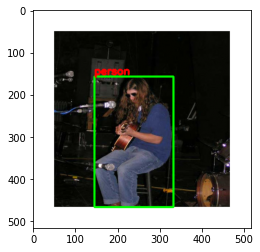

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


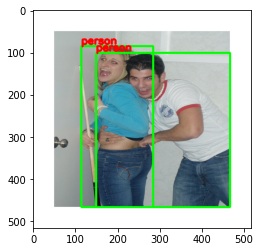

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


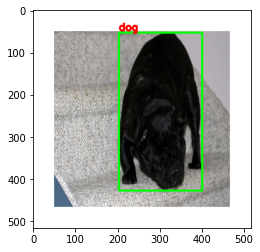

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


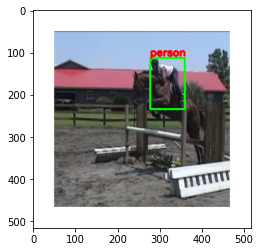

In [22]:
for i in range(4):
    demo_plot_img(i)

## 4. Kiến trúc mô hình

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Lambda, LeakyReLU
from tensorflow.keras.layers import Concatenate

Điểm mới nổi bật nhất trong trong kiến trúc YOLOv2 so với YOLOv1 là sử dụng các tầng ***Batch Normalization***. Activation function dùng cho các tầng Convolution vẫn là ***Leaky ReLU***

In [24]:
def ConvBlock(x, filters, kernel_size, index, trainable=True):
    x = Conv2D(filters, kernel_size, padding='same', name='conv_' + str(index),
               trainable=trainable, use_bias=False)(x)
    x = BatchNormalization(name='norm_' + str(index))(x)
    x = LeakyReLU(alpha=0.1, name='leaky_' + str(index))(x)
    return x

Vì ta cần cài đặt nhiều khối `ConvBlock` liên tiếp nhau nên để thuận tiện thì ta sẽ viết 1 hàm hỗ trợ điều này

In [25]:
def ConvBlock_stack(x, index, conv_stack, trainable):
    for param in conv_stack:
        x = ConvBlock(x, param["filters"], param["kernel_size"], index, trainable)
        index += 1
    return(x)

Kiến trúc mô hình:

***Lưu ý***: Đối với Input, ngoài ảnh thì ta sử dụng thêm `true_boxes`. Vai trò của nó là chứa các bounding box của object có trong ảnh. Mục đích của điều này là sử dụng cho hàm loss (ta sẽ đề cập sau)

In [90]:
def YOLOv2(img_size, grid_size, true_box_buffer, n_abox, n_class, trainable=False):
    '''
    Arguments:
        `img_size`: The input image size in pixels (416 or 608)
        `grid_size`: The number of grid cells per input image (ex 13)
        `true_box_buffer`: the number of bounding box in an image (ex 50)
        `n_abox`: the number of anchor boxes
        `n_class`: the number of classes
        `trainable`: determine if the model is trainable
    '''

    # The number of filters and kernel_sizes of the convolution layers
    conv_stack_3_5 = [{"filters": 128, "kernel_size": (3, 3)},  # 3
                      {"filters": 64,  "kernel_size": (1, 1)},  # 4
                      {"filters": 128, "kernel_size": (3, 3)}]  # 5

    conv_stack_6_8 = [{"filters": 256, "kernel_size": (3, 3)},  # 6
                      {"filters": 128, "kernel_size": (1, 1)},  # 7
                      {"filters": 256, "kernel_size": (3, 3)}]  # 8

    conv_stack_9_13 = [{"filters": 512, "kernel_size": (3, 3)},  # 9
                       {"filters": 256, "kernel_size": (1, 1)},  # 10
                       {"filters": 512, "kernel_size": (3, 3)},  # 11
                       {"filters": 256, "kernel_size": (1, 1)},  # 12
                       {"filters": 512, "kernel_size": (3, 3)}]  # 13

    conv_stack_14_20 = [{"filters": 1024, "kernel_size": (3, 3)},  # 14
                        {"filters": 512,  "kernel_size": (1, 1)},  # 15
                        {"filters": 1024, "kernel_size": (3, 3)},  # 16
                        {"filters": 512,  "kernel_size": (1, 1)},  # 17
                        {"filters": 1024, "kernel_size": (3, 3)},  # 18
                        {"filters": 1024, "kernel_size": (3, 3)},  # 19
                        {"filters": 1024, "kernel_size": (3, 3)}]  # 20

    input_image = Input(shape=(img_size, img_size, 3), name="input_image")
    true_boxes = Input(shape=(1, 1, 1, true_box_buffer, 4), name="input_hack")

    # Layer 1
    x = ConvBlock(input_image, filters=32, kernel_size=(3, 3),
        index=1, trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_416to208")(x)

    # Layer 2
    x = ConvBlock(x, filters=64, kernel_size=(3, 3),
        index=2, trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_208to104")(x)

    # Layer 3 - 5
    x = ConvBlock_stack(x, index=3, conv_stack=conv_stack_3_5, trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_104to52")(x)

    # Layer 6 - 8
    x = ConvBlock_stack(x, index=6, conv_stack=conv_stack_6_8, trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_52to26")(x)

    # Layer 9 - 13
    x = ConvBlock_stack(x, index=9, conv_stack=conv_stack_9_13, trainable=trainable)

    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2), name="maxpool1_26to13")(x)

    # Layer 14 - 20
    x = ConvBlock_stack(x, index=14, conv_stack=conv_stack_14_20, trainable=trainable)

    # Layer 21
    skip_connection = ConvBlock(skip_connection, filters=64,
                                kernel_size=(1, 1), index=21, trainable=trainable)
    skip_connection = Lambda(lambda x: tf.nn.space_to_depth(x, block_size=2))(skip_connection)

    x = Concatenate()([skip_connection, x])

    # Layer 22
    x = ConvBlock(x, filters=1024, kernel_size=(3, 3), index=22, trainable=trainable)

    # Layer 23
    x = Conv2D(filters=n_abox * (4 + 1 + n_class), kernel_size=(1, 1), strides=(1, 1),
               padding='same', name='conv_23')(x)
    output = Reshape((grid_size, grid_size, n_abox, 4 + 1 + n_class),
                     name="final_output")(x)

    # small hack to allow true_boxes to be registered when Keras build the model
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = Lambda(lambda args: args[0], name="hack_layer")(
        [output, true_boxes])

    model = Model([input_image, true_boxes], output)
    return model, true_boxes

Ta sẽ không train phần backbone (22 layers đầu tiên), do đó tham số `trainable` sẽ là `False`

In [139]:
IMG_SIZE = 416
GRID_SIZE = 13
TRUE_BOX_BUFFER = 50
BATCH_SIZE = 32
N_ABOX = len(ANCHORS)
N_CLASS = len(CLASSES)

demo_model, demo_true_boxes = YOLOv2(IMG_SIZE, GRID_SIZE, TRUE_BOX_BUFFER, N_ABOX, N_CLASS, trainable=False)
demo_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_1 (LeakyReLU)             (None, 416, 416, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

Tải pre-trained weights cho backbone: https://pjreddie.com/media/files/yolov2.weights

In [34]:
weights_path = "./yolov2.weights"

Ta cần gán giá trị weights này cho 22 ConvBlock (các layer `conv_i` và `norm_i`).

Đầu tiên là class `WeightReader` để đọc các giá trị từ file

In [27]:
class WeightReader:
    def __init__(self, weights_file):
        self.offset = 4
        self.all_weights = np.fromfile(weights_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[(self.offset - size):self.offset]
    
    def reset(self):
        self.offset = 4

Thử chạy class `WeightReader`:

In [36]:
demo_weight_reader = WeightReader(weights_path)
print("all_weights.shape =", demo_weight_reader.all_weights.shape)

all_weights.shape = (50983565,)


Hàm gán weights cho các layers:

In [28]:
def set_pretrained_weight(model, n_conv_block, weights_path):
    weight_reader = WeightReader(weights_path)
    weight_reader.reset()

    for i in range(1, n_conv_block + 1):
        conv_layer = model.get_layer('conv_' + str(i))

        # Don't set weights for norm_22 (?)
        if i < n_conv_block:
            norm_layer = model.get_layer('norm_' + str(i))

            size = np.prod(norm_layer.get_weights()[0].shape)

            beta = weight_reader.read_bytes(size)
            gamma = weight_reader.read_bytes(size)
            mean = weight_reader.read_bytes(size)
            var = weight_reader.read_bytes(size)

            norm_layer.set_weights([gamma, beta, mean, var])

        # If the conv_layer has biases:
        if len(conv_layer.get_weights()) > 1:
            bias = weight_reader.read_bytes(
                np.prod(conv_layer.get_weights()[1].shape))
            kernel = weight_reader.read_bytes(
                np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(
                list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2, 3, 1, 0])
            conv_layer.set_weights([kernel, bias])
        else:
            # Otherwise
            kernel = weight_reader.read_bytes(
                np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(
                list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2, 3, 1, 0])
            conv_layer.set_weights([kernel])
            
    return model


Chạy thử hàm `set_pretrained_weight`:

In [40]:
n_conv_block = 22
demo_model = set_pretrained_weight(demo_model, n_conv_block, weights_path)

Khởi tạo trọng số cho layer 23 (layer convolution cuối cùng)

In [29]:
def initialize_weight(layer, sd):
    weights = layer.get_weights()
    kernel = np.random.normal(size=weights[0].shape, scale=sd)
    bias = np.random.normal(size=weights[1].shape, scale=sd)
    layer.set_weights([kernel, bias])


Chạy thử hàm `initialize_weight`:

In [42]:
layer = demo_model.layers[-4]
initialize_weight(layer, sd=1/(GRID_SIZE*GRID_SIZE))

## 5. Hàm loss

***Sad:*** Trong paper của YOLOv2, các tác giả không đề cập cụ thể về hàm loss 😥

Công thức hàm loss của **YOLOv1** như sau:
$$ L = L_{confidence} + L_{localization} + L_{classification}$$
$$L_{confidence} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} (C_i - \hat{C_i})^2 + \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{noobj} (C_i - \hat{C_i})^2 $$
$$L_{localization} = \lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} \left [ (x_i - \hat{x_i})^2 + (y_i - \hat{y_i})^2  + (\sqrt{w_i} - \sqrt{\hat{w_i}})^2 + (\sqrt{h_i} - \sqrt{\hat{h_i}})^2 \right ] $$
$$L_{classification} = \sum_{i=0}^{S^2} \mathbb{I}_{i}^{obj} \sum_{c \in classes} (p_i(c) - \hat{p_i}(c))^2$$

Với **YOLOv2**, về cơ bản, ta sẽ sử dụng công thức tương tự như trên. Tuy nhiên, thay vì chỉ áp dụng hàm loss cho label với 1 box tại mỗi ô lưới như YOLOv1, ta sẽ áp dụng cho tất cả các anchor box. Từ đó, công thức các hàm loss thành phần của ta như sau:
$$L_{confidence} = \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} (C_{i,j} - \hat{C_{i,j}})^2 + \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{noobj} (C_{i,j} - \hat{C_{i,j}})^2 $$
$$L_{localization} = \lambda_{coord} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{ij}^{obj} \left [ (x_{i,j} - \hat{x_{i,j}})^2 + (y_{i,j} - \hat{y_{i,j}})^2  + (\sqrt{w_{i,j}} - \sqrt{\hat{w_{i,j}}})^2 + (\sqrt{h_{i,j}} - \sqrt{\hat{h_{i,j}}})^2 \right ] $$
$$L_{classification} = -\sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{I}_{i,j}^{obj} \sum_{c \in classes} (p_{i,j}^c \log \left ( \hat{p}_{i,j}^c \right ))$$

Trong đó:
- $i$ chỉ ô lưới thứ $i$, $j$ chỉ anchor box thứ $j$ trong ô lưới đó
- $x_{i,j}$ và các giá trị tọa độ tâm khác cũng là ***độ dời tương đối*** như YOLOv1
- $C_{i,j}$ là IOU giữa label của anchor box thứ $j$ của ô lưới $i$ và giá trị dự đoán của nó
- Đối với loss phân loại, ta sẽ sử dụng hàm cross-entropy

***Lưu ý***: Output cho mỗi anchor box là vector có chiều $4 + 1 + n_{classes}$

### 5.1. Chuẩn hóa lại giá trị output

Vì layer 23 (layer cuối cùng) của mô hình sử dụng activation function tuyến tính nên ta cần chuẩn hóa các giá trị đó. Theo paper gốc, ta chuẩn hóa như sau:

<img src="./bbox_adjust.jpg"/>

Trong đó
- Các giá trị output của mô hình là $t_x, t_y, t_w, t_h$
- Ngoài ra, giá trị confidence và xác suất của các class cũng cần đảm bảo thuộc [0, 1]. Ta sẽ áp dụng ***sigmoid*** cho confidence và ***softmax*** cho xác suất của các class

Đầu tiên, ta cần tạo ra 2 bảng `board_x`, `board_y` tương tự như sau:
```python
board_x = [[0, 1, 2, 3]
           [0, 1, 2, 3]
           [0, 1, 2, 3]
           [0, 1, 2, 3]]
board_y = [[0, 0, 0, 0]
           [1, 1, 1, 1]
           [2, 2, 2, 2]
           [3, 3, 3, 3]]
```
Đồng thời, ta sẽ stack 2 bảng lại với nhau --> (GRID_SIZE, GRID_SIZE, N_BOX, 2)

In [30]:
def board_coords(grid_size, batch_size, n_abox):
# def board_coords(grid_size):
    '''
    Arguments:
        `grid_size`: the number of grid cells in horizontal (or vertical)
    Return:
        `full_board`: Tensor of shape (1, grid_size, grid_size, 1, 2)
    '''
    board_x = tf.reshape(tf.tile(tf.range(grid_size), [
                         grid_size]), (1, grid_size, grid_size, 1, 1))
    board_y = tf.transpose(board_x, (0, 2, 1, 3, 4))
    full_board = tf.concat([board_x, board_y], axis=-1)
    full_board = tf.tile(full_board, [batch_size, 1, 1, n_abox, 1])
    return tf.cast(full_board, tf.float32)


Hàm chuẩn hóa giá trị output:

In [31]:
def adjust_scale_prediction(y_pred, full_board, ANCHORS):
    """
    Arguments:
        `y_pred`: A tensor of shape (batch_size, grid_size, grid_size, n_abox, 4 + 1 + n_class)
        `full_board`: A tensor of shape (batch_size, grid_size, grid_size, n_abox, 2)
        `ANCHORS`: A list of anchor boxes
    """
    n_abox = len(ANCHORS)

    # Use sigmoid function
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + full_board

    # Use exp function
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, n_abox, 2])

    # Confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])

    # Class probabilities
    pred_box_class = y_pred[..., 5:]

    return pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class


### 5.2. Trích xuất label

In [32]:
def extract_label(label):
    '''
    Arguments:
        `label`: A tensor of shape (batch_size, grid_size, grid_size, n_abox, 4 + 1 + n_class)
    Return:
        `true_box_xy`, `true_box_wh`, `true_box_conf`, `true_box_class`
    '''
    true_box_xy = label[..., 0:2]
    true_box_wh = label[..., 2:4]
    true_box_conf = label[..., 4]
    true_box_class = tf.argmax(label[..., 5:], -1)
    return true_box_xy, true_box_wh, true_box_conf, true_box_class

### 5.3. Tính localization loss

Giá trị `mask` trong hàm bên dưới chính là $\mathbb{I}_{ij}^{obj}$ trong công thức của phần loss này

In [33]:
def localize_loss(true_box_conf, n_coord, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh):
    '''
    Arguments:
        `true_box_conf`: shape (batch_size, grid_size, grid_size, n_abox, 1)
        `n_coord`: lambda of localization loss
        `true_box_xy`, `pred_box_xy`, `true_box_wh`, `pred_box_wh`:
            shape (batch_size, grid_size, grid_size, n_abox, 2)
    Return:
        `loss`: localization loss
    '''
    mask = tf.expand_dims(true_box_conf, axis=-1) * n_coord
    #   --> (batch_size, grid_size, grid_size, n_abox, 2)

    # The number of object in this batch
    n_coord_box = tf.reduce_sum(tf.cast(mask > 0.0, tf.float32))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * mask)
    loss_xy = loss_xy  / (n_coord_box + 1e-6) / 2.

    loss_wh = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * mask)
    loss_wh = loss_wh  / (n_coord_box + 1e-6) / 2.

    loss = loss_xy + loss_wh
    return loss


### 5.4. Tính classification loss

Tương tự như trên, giá trị `mask` trong hàm bên dưới cũng chính là $\mathbb{I}_{ij}^{obj}$ trong công thức của phần loss này

In [52]:
def class_loss(true_box_conf, true_box_class, pred_box_class):
    '''
    Arguments:
        `true_box_conf`: shape (batch_size, grid_size, grid_size, n_abox, 1)
        `n_coord`: lambda of localization loss
        `true_box_class`: shape (batch_size, grid_size, grid_size, n_abox)
        `pred_box_class`: shape (batch_size, grid_size, grid_size, n_abox, n_class)     
    Return:
        `loss`: classification loss
    '''   
    mask = true_box_conf
    n_class_box = tf.reduce_sum(tf.cast(mask > 0.0, tf.float32))
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, 
                                                          logits=pred_box_class)
    loss = tf.reduce_sum(loss * mask) / (n_class_box + 1e-6)   
    return loss


### 5.5. Tính confidence loss

Đầu tiên, ta cần viết hàm tính IOU giữa bounding box dự đoán và label (hàm này không giống như hàm IOU ở phần đầu vì nó không đưa 2 box về cùng đỉnh top-left)

In [35]:
def iou_general(true_xy, true_wh, pred_xy,pred_wh):
    '''
    Arguments:
        `true_xy`: shape (batch_size, grid_size, grid_size, n_abox, 2)
        Similar to `pred_xy`, `true_wh`, `pred_wh`

    Note: the shape of arguments might be different but they must have the same shape length
    (ex using broadcasting)
    '''
    true_mins    = true_xy - true_wh / 2.0
    true_maxes   = true_xy + true_wh / 2.0

    pred_mins    = pred_xy - pred_wh / 2.0
    pred_maxes   = pred_xy + pred_wh / 2.0    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    union_areas = pred_areas + true_areas - intersect_areas

    iou_scores  = intersect_areas / union_areas

    return iou_scores

Giá trị $C_{i,j}$ trong công thức hàm loss:
- Bằng IOU giữa label của anchor box thứ $j$ tại ô lưới $i$ và giá trị dự đoán của nó nếu true_conf của anchox box này là 1
- Ngược lại, 0

In [36]:
def iou_Cij(true_box_conf, true_box_xy, true_box_wh, pred_box_xy,  pred_box_wh):
    '''
    Arguments:
        `true_box_conf`: shape (batch_size, grid_size, grid_size, n_abox, 1)
        `true_box_xy`, `true_box_wh`, `pred_box_xy`, `pred_box_wh`:
            shape (batch_size, grid_size, grid_size, n_abox, 2)
    Return:
        `true_box_IOU`: shape (batch_size, grid_size, grid_size, n_abox)
    '''
    iou_scores = iou_general(true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return true_box_conf_IOU


Đối với confidence loss, ta cần chú ý đến các giá trị $\mathbb{I}_{ij}^{obj}$ và $\mathbb{I}_{ij}^{noobj}$:
- $\mathbb{I}_{ij}^{obj}$ là `true_box_conf` như những phần loss trước
- Trong khi đó
$$\mathbb{I}_{ij}^{noobj} = \left\{\begin{matrix}
1 \text{ nếu } \underset{i',j'}{\max}\;IOU_{i,j \text{ predicted}}^{i', j' \text{ true boxes}} < 0.6 \text{ và } C_{i,j}=0 \\
\\
0 \text{ else}
\end{matrix}\right.$$

Do đó, ta cần tính xem với mỗi anchor box $j$ tại ô lưới $i$, giá trị IOU lớn nhất của nó với 1 bounding box nào đó trong ảnh là bao nhiêu.

***Ảo:*** Đây là lý do ta đã lưu thêm `b_batch` và giá trị `TRUE_BOX_BUFFER` ở phần xây dựng lớp `MyGenerator`

In [67]:
def find_best_ious(pred_xy, pred_wh, true_boxes):
    '''
    Arguments:
        `pred_xy`, `pred_wh`:
            shape (batch_size, grid_size, grid_size, n_abox, 2)
        `true_boxes`: shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)
    Return:
        `best_ious`: shape (batch_size, grid_size, grid_size, n_abox)
    '''
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    # Expand pred_xy and pred_wh to (batch_size, grid_size, grid_size, n_abox, 1, 2)
    pred_xy_new = tf.expand_dims(pred_xy, 4)
    pred_wh_new = tf.expand_dims(pred_wh, 4)

    iou_scores = iou_general(true_xy, true_wh, pred_xy_new, pred_wh_new)
    # ---> (batch_size, grid_size, grid_size, n_abox, TRUE_BOX_BUFFER)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    return best_ious

Hàm tính confidence loss:

In [96]:
def conf_loss(true_box_conf, pred_box_conf, n_noobj, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh, true_boxes):
    '''
    Arguments:
        `true_box_conf` and `pred_box_conf`:
            shape (batch_size, grid_size, grid_size, n_abox)
        `n_noobj`: lambda of confidence loss (no object part)
        `true_box_xy`, `true_box_wh`, `pred_box_xy`, `pred_box_wh`:
            shape (batch_size, grid_size, grid_size, n_abox, 2)
        `true_boxes`: shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)
    Return:
        `loss`: confidence loss
    '''
    # Compute Cij
    true_box_conf_IOU = iou_Cij(true_box_conf, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
    
    # Find best iou for each anchor box
    best_ious = find_best_ious(pred_box_xy, pred_box_wh, true_boxes)

    # Confidence mask: object part and no object part
    conf_mask = (tf.cast(best_ious < 0.6, tf.float32) * true_box_conf) * n_noobj
    conf_mask = conf_mask + true_box_conf

    # "Mean" over batch
    n_conf_box = tf.reduce_sum(tf.cast(conf_mask > 0.0, tf.float32))

    # Loss
    loss = tf.reduce_sum(tf.square(true_box_conf_IOU - pred_box_conf) * conf_mask)  / (n_conf_box  + 1e-6) / 2.
    
    return loss


### 5.6. Hàm tính loss của mô hình

In [39]:
N_NOOBJ = 1.0
N_COORD = 5.0

In [91]:
# def final_loss(y_true, y_pred, n_coord, n_noobj, grid_size, ANCHORS, true_boxes):
#     '''
#     Arguments:
#         `y_true`, `y_pred: shape (batch_size, grid_size, grid_size, n_abox, 4 + 1 + n_classes)
#         `n_coord`: lambda of coordinate loss
#         `n_noobj`: lambda of confidence loss (no object part)
#         `grid_size`: grid size
#         `ANCHORS`: list of anchor boxes
#         `true_boxes`: shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)
#     '''
#     batch_size = y_true.shape[0]
#     n_abox = y_true.shape[3]
#     full_board = board_coords(grid_size)
#     full_board = tf.tile(full_board, [batch_size, 1, 1, n_abox, 1])

#     # Extract and scale y_ped
#     pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred, full_board, ANCHORS)

#     # Extract and scale y_true
#     true_box_xy, true_box_wh, true_box_conf, true_box_class = adjust_scale_prediction(y_true, full_board, ANCHORS)

#     # Compute the loss
#     loss = 0
#     loss += class_loss(true_box_conf, true_box_class, pred_box_class)
#     loss += localize_loss(true_box_conf, n_coord, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
#     loss += conf_loss(true_box_conf, pred_box_conf, n_noobj, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh, true_boxes)
#     return loss

In [109]:
def yolo_loss(y_true, y_pred):
    '''
    Arguments:
        `y_true` and `y_pred: shape (batch_size, grid_size, grid_size, n_abox, 4 + 1 + n_class)
    Return:
        `loss`: loss of the model over current batch
    '''
    # batch_size = tf.shape(y_true)[0]
    # n_abox = tf.shape(y_true)[3]
    # full_board = board_coords(GRID_SIZE)
    # full_board = tf.tile(full_board, [BATCH_SIZE, 1, 1, N_ABOX, 1])
    full_board = board_coords(GRID_SIZE, BATCH_SIZE, N_ABOX)
    # Extract and scale y_ped
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred, full_board, ANCHORS)

    # Extract and scale y_true
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_label(y_true)

    # Compute the loss
    loss1 = class_loss(true_box_conf, true_box_class, pred_box_class)
    loss2 = localize_loss(true_box_conf, N_COORD, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
    loss3 = conf_loss(true_box_conf, pred_box_conf, N_NOOBJ, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh, true_boxes)
    
    loss = loss1 + loss2 + loss3
    print('loss log')
    # print(loss.numpy())

    return loss

Trong cài đặt của hàm `yolo_loss`, ta không hề truyền tham số `true_boxes`. Làm thế nào mà chương trình có thể biết được nó là gì?

Quay lại phần định nghĩa hàm, ta đã cài đặt input của mô hình bao gồm cả ảnh và true_boxes của ảnh đó, điều này sẽ đưa true_boxes vào đồ thị tính toán của Tensorflow, do đó ta có thể làm được điều trên.

## 6. Training

Ta sẽ giải phóng bộ nhớ cho những biến đã tạo ở phía trên, vì nó chỉ mang tính minh họa

In [41]:
demo_model = None
demo_generator = None
demo_true_boxes = None
demo_weight_reader = None
input_batch = None
x_batch = None
b_batch = None
y_batch = None

Thiết lập các tham số:

In [42]:
ANCHORS = np.array([[0.08264212, 0.13575117],
                    [0.41898774, 0.6221668],
                    [0.80433065, 0.77523612],
                    [0.20665115, 0.3896164]])
                    
CLASSES = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle',
           'bus',        'car',      'cat',  'chair',     'cow',
           'diningtable', 'dog',    'horse',  'motorbike', 'person',
           'pottedplant', 'sheep',  'sofa',   'train',   'tvmonitor']

In [43]:
BATCH_SIZE = 32
IMG_SIZE = 416
GRID_SIZE = 13
TRUE_BOX_BUFFER = 50
N_CLASS = len(CLASSES)
N_ABOX = len(ANCHORS)
N_NOOBJ = 1.0
N_COORD = 5.0

config = {
    'IMAGE_SIZE': 416,
    'GRID_SIZE': 13,
    'CLASSES': CLASSES,
    'ANCHORS': ANCHORS,
    'BATCH_SIZE': BATCH_SIZE,
    'TRUE_BOX_BUFFER': TRUE_BOX_BUFFER,
}

Tạo Generator cho trainig và testing:

In [97]:
train_generator = MyGenerator(train_anns, config, norm=normalize, shuffle=True)
val_generator = MyGenerator(val_anns, config, norm=normalize, shuffle=True)

Định nghĩa mô hình:

In [98]:
model, true_boxes = YOLOv2(IMG_SIZE, GRID_SIZE, TRUE_BOX_BUFFER, N_ABOX, N_CLASS, trainable=False)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_1 (LeakyReLU)             (None, 416, 416, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

Khởi tạo trọng số cho mô hình:

In [99]:
weights_path = './yolov2.weights'
n_conv_block = 22
model = set_pretrained_weight(model, n_conv_block, weights_path)
layer = model.layers[-4]  # the last convolutional layer
initialize_weight(layer, sd=1/(GRID_SIZE*GRID_SIZE))

Biên dịch mô hình:

In [74]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [116]:
optimizer = Adam(lr=1e-4)
model.compile(loss=yolo_loss, optimizer=optimizer, experimental_run_tf_function=False)

Early Stopping và Checkpoint:

In [101]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [102]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.001,
                           patience=5,
                           mode='min')

checkpoint = ModelCheckpoint('train_weights.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

Train thôi!

In [120]:
model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stop, checkpoint])

ValueError: Calling `Model.fit` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.fit` with eager mode enabled.